# Getting started with the Monitoring API

Cloud Datalab provides an environment for working with your data. This includes data that is being managed within the Monitoring API. This notebook introduces some of the APIs that Cloud Datalab provides for working with the monitoring data, and allows you to try them out on your own project.

The main focus of this API is to allow you to query timeseries data for your monitored resources. There are also commands to help you list the available metrics and resource types.

**Note**: This notebook will show you how to use this API by running it on your own project. For all cells to run without errors, the following must hold:
* The default project must be set
* This project must have at least one GCE Instance. You can create an instance at the following link: [https://console.cloud.google.com/compute/instances](https://console.cloud.google.com/compute/instances)

## Importing the API and setting up the default project

The Monitoring functionality is contained within the `datalab.stackdriver.monitoring` module.

If there is no default project set already, you must do so using `'set_datalab_project_id'`.

In [1]:
from datalab.stackdriver import monitoring as gcm

# set_datalab_project_id('my-project-id')

## List names of Compute Engine CPU metrics

Here we can see that `instance_name` is a metric label.

In [2]:
%%monitoring list metrics --type compute*/cpu/*

Metric type,Kind,Value,Labels
compute.googleapis.com/instance/cpu/reserved_cores,GAUGE,DOUBLE,instance_name
compute.googleapis.com/instance/cpu/usage_time,DELTA,DOUBLE,instance_name
compute.googleapis.com/instance/cpu/utilization,GAUGE,DOUBLE,instance_name


## List monitored resource types related to GCE

In [3]:
%%monitoring list resource_types --type gce*

Resource type,Labels
gce_disk,"project_id, disk_id, zone"
gce_instance,"project_id, instance_id, zone"
gce_router,"project_id, router_id, region"


## Querying timeseries data

The `gcm.Query` class allows users to query and access the monitoring timeseries data. The results of the query can be accessed as a `pandas` `DataFrame` object. `pandas` is a widely used library for data manipulation:

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

You can also get help from inside the notebook by calling the `help` function on any class, object or method.

In [4]:
help(gcm.Query.select_metrics)

Help on method select_metrics in module gcloud.monitoring.query:

select_metrics(self, *args, **kwargs) unbound datalab.stackdriver.monitoring._timeseries.Query method
    Copy the query and add filtering by metric labels.
    
    Examples::
    
        query = query.select_metrics(instance_name='myinstance')
        query = query.select_metrics(instance_name_prefix='mycluster-')
    
    A keyword argument ``<label>=<value>`` ordinarily generates a filter
    expression of the form::
    
        metric.label.<label> = "<value>"
    
    However, by adding ``"_prefix"`` or ``"_suffix"`` to the keyword,
    you can specify a partial match.
    
    ``<label>_prefix=<value>`` generates::
    
        metric.label.<label> = starts_with("<value>")
    
    ``<label>_suffix=<value>`` generates::
    
        metric.label.<label> = ends_with("<value>")
    
    :type args: tuple
    :param args: Raw filter expression strings to include in the
        conjunction. If just one is provided a

### Initializing the query

During intialization, the metric type and the time interval need to be specified. For interactive use, the metric type has a default value. The simplest way to specify the time interval that ends `now` is to use the arguments `days`, `hours`, and `minutes`.

In [5]:
query_cpu = gcm.Query('compute.googleapis.com/instance/cpu/utilization', hours=2)

### Getting the metadata

The method `metadata()` returns a `QueryMetadata` object. It contains the following information about the timeseries matching the query:
* resource types
* resource labels and their values
* metric labels and their values

This helps you understand the structure of the timeseries data, and makes it easier to modify the query.

In [6]:
metadata_cpu = query_cpu.metadata().as_dataframe()
metadata_cpu.head(5)

resource     resource.labels                                      \
           type          project_id           zone          instance_id   
0  gce_instance  monitoring-datalab  us-central1-b  7900261093938609905   
1  gce_instance  monitoring-datalab     us-east1-d  5437900963820317613   

           metric.labels  
           instance_name  
0  gae-datalab-main-j642  
1               analyst2

Next, we read in the instance names from the metadata, and use it in filtering the timeseries data below. If there are no GCE instances in this project, the cells below will raise errors.

In [7]:
import sys

if metadata_cpu.empty:
  sys.stderr.write('This project has no GCE instances. The remaining notebook will raise errors!')
else:
  instance_names = list(metadata_cpu['metric.labels']['instance_name'])
  print 'First 5 instance names: %s' % (instance_names[:5],)

First 5 instance names: [u'gae-datalab-main-j642', u'analyst2']


### Refining the query

Many useful methods of the `Query` class are actually defined by the base class, which is provided by the `gcloud-python` library. These methods include `select_metrics()`, `select_resources()`, `align()`, `reduce()`, and `as_dataframe()`, among others. We demonstrate some of these below. Reference documentation for the `Query` base class is available [here](http://gcloud-python.readthedocs.org/en/latest/monitoring-query.html).


### Filtering by label

Here, we filter the query to include only the first instance.

In [8]:
query_cpu_single_instance = query_cpu.select_metrics(instance_name=instance_names[0])

# Get the query results as a pandas DataFrame and look at the last 5 rows.
data_single_instance = query_cpu_single_instance.as_dataframe(label='instance_name')
data_single_instance.tail(5)

,gae-datalab-main-j642
2016-08-03 23:06:01.763,0.009473
2016-08-03 23:07:01.763,0.008786
2016-08-03 23:08:01.763,0.007694
2016-08-03 23:09:01.763,0.008299
2016-08-03 23:10:01.763,0.007534


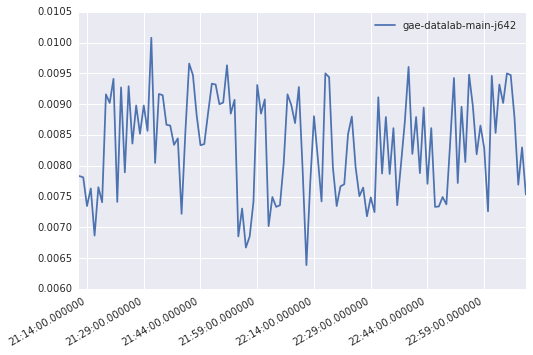

In [9]:
# N.B. A useful trick is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

_ = data_single_instance.plot()

### Aligning the query

For multiple timeseries, aligning the data is recommended. The alignment offset can be specified using the arguments `hours`, `minutes`, and `seconds`.

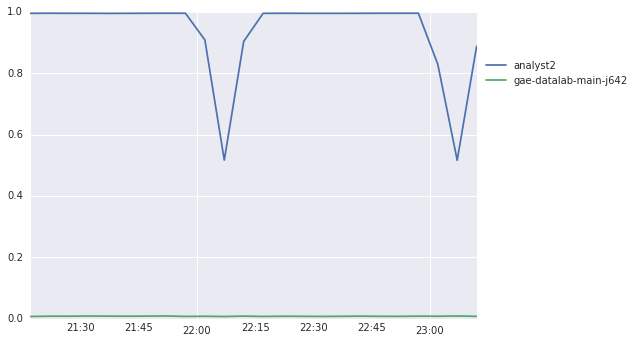

In [10]:
# Align the query to have data every 5 minutes.
query_cpu_aligned = query_cpu.align('ALIGN_MEAN', minutes=5)
data_all_instances = query_cpu_aligned.as_dataframe(label='instance_name')

# Display the data as a linechart. The extra code moves the legend to the 
# right of the chart.
_ = data_all_instances.plot().legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

### Displaying the results as a heatmap

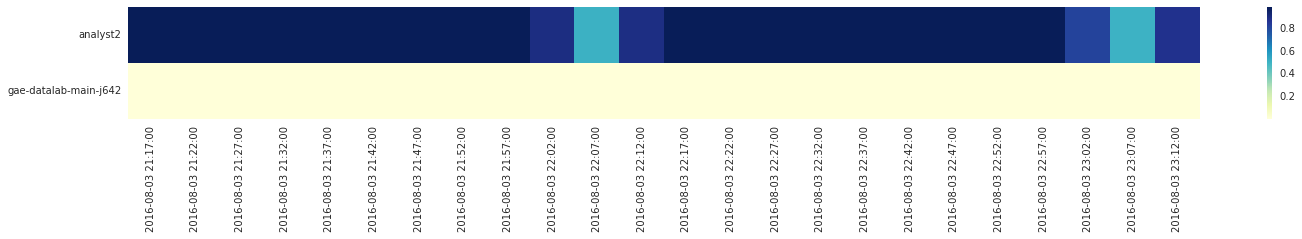

In [11]:
import matplotlib
import seaborn

# Set the size of the heatmap to have a better aspect ratio.
matplotlib.pyplot.figure(figsize=data_all_instances.shape)
_ = seaborn.heatmap(data_all_instances.T, xticklabels=data_all_instances.index.map(str), cmap='YlGnBu')

### Reducing the query

In order to aggregate the timeseries data, the `reduce()` method can be used. The fields to be retained after aggregation must be specified in the method.

For example, to aggregate the results by the zone, `'resource.zone'` can be specified.

In [12]:
query_cpu_reduced = query_cpu_aligned.reduce('REDUCE_MEAN', 'resource.zone')
data_per_zone = query_cpu_reduced.as_dataframe('zone')
data_per_zone.tail(5)

,us-central1-b,us-east1-d
2016-08-03 22:52:00,0.008003,0.995619
2016-08-03 22:57:00,0.008637,0.995730
2016-08-03 23:02:00,0.008369,0.829574
2016-08-03 23:07:00,0.009169,0.516721
2016-08-03 23:12:00,0.008078,0.887553


## Multi-level headers

If you don't provide any labels to `as_dataframe`, it returns all the resource and metric labels present in the timeseries as a multi-level header.

This allows you to filter, and aggregate the data more easily.

In [13]:
data_multi_level = query_cpu_aligned.as_dataframe()
data_multi_level.tail(5)

resource_type                gce_instance                    
project_id             monitoring-datalab                    
zone                        us-central1-b          us-east1-d
instance_id           7900261093938609905 5437900963820317613
instance_name       gae-datalab-main-j642            analyst2
2016-08-03 22:52:00              0.008003            0.995619
2016-08-03 22:57:00              0.008637            0.995730
2016-08-03 23:02:00              0.008369            0.829574
2016-08-03 23:07:00              0.009169            0.516721
2016-08-03 23:12:00              0.008078            0.887553

### Filter the dataframe

In [14]:
pattern = instance_names[0].split('-')[0]
print 'Finding pattern %r in the dataframe headers' % (pattern,)

Finding pattern u'gae' in the dataframe headers


In [15]:
data_multi_level.filter(regex=pattern).tail(5)

resource_type,gce_instance
project_id,monitoring-datalab
zone,us-central1-b
instance_id,7900261093938609905
instance_name,gae-datalab-main-j642
2016-08-03 22:52:00,0.008003
2016-08-03 22:57:00,0.008637
2016-08-03 23:02:00,0.008369
2016-08-03 23:07:00,0.009169
2016-08-03 23:12:00,0.008078


### Aggregate columns in the dataframe

In [16]:
data_multi_level.groupby(level='zone', axis=1).mean().tail(5)

zone,us-central1-b,us-east1-d
2016-08-03 22:52:00,0.008003,0.995619
2016-08-03 22:57:00,0.008637,0.995730
2016-08-03 23:02:00,0.008369,0.829574
2016-08-03 23:07:00,0.009169,0.516721
2016-08-03 23:12:00,0.008078,0.887553
